In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10000)
from config import sub_days

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

from tqdm.notebook import tqdm

In [4]:
sp_df = pd.read_csv('sell_prices.csv')
cal_df = pd.read_csv('calendar.csv')
train_df = pd.read_csv('sales_train_validation.csv')
sub_df = pd.read_csv('sample_submission.csv')

agg_preds = pd.read_csv('agg_preds2.csv')
foods_item_preds = pd.read_csv('foods_item_preds.csv')
hobbie_item_preds = pd.read_csv('hobbie_item_preds.csv')
household_item_preds = pd.read_csv('household_item_preds.csv')

val_sub_df = sub_df.loc[sub_df.id.str.contains('validation')]

In [5]:
id_cols = ['id', 'state_id', 'store_id', 'dept_id', 'item_id']
day_cols = [col for col in train_df.columns if col.startswith('d_')]
f_cols = ['F' + str(d) for d in range(1, 29)]
cal_df['y_m'] = pd.to_datetime(cal_df.date.str[:-3] + '-01')

train_df['total_sold'] = train_df[day_cols].sum(axis=1)
train_df['state_cat_id'] = train_df['state_id'] + '_' + train_df['cat_id']
train_df['state_dept_id'] = train_df['state_id'] + '_' + train_df['dept_id']
train_df['state_item_id'] = train_df['state_id'] + '_' + train_df['item_id']
train_df['store_cat_id'] = train_df['store_id'] + '_' + train_df['cat_id']
train_df['store_dept_id'] = train_df['store_id'] + '_' + train_df['dept_id']

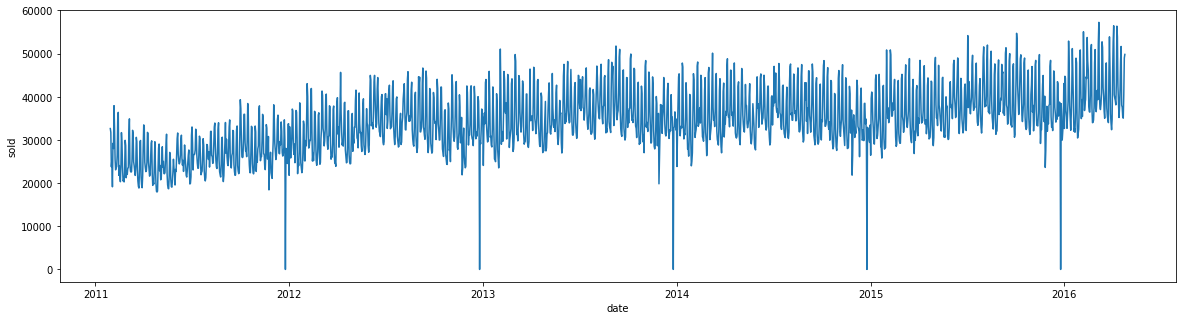

In [6]:
total_sold_per_day = pd.DataFrame(train_df[day_cols].sum()).reset_index()
total_sold_per_day.columns = ['d', 'sold']

merged_total_sold_per_day = total_sold_per_day.merge(cal_df, on = 'd')
merged_total_sold_per_day['date'] = pd.to_datetime(merged_total_sold_per_day['date'])

plt.figure(figsize=(20,5))
sns.lineplot(x = 'date', y = 'sold', data = merged_total_sold_per_day)

In [7]:
def mean_absolute_percentage_errer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), y_pred
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_perc_of_items_sold_per_dept(train_df, cal_df, month, year):
    subset_cal = cal_df.loc[(cal_df.y_m.dt.month == month) & \
                            (cal_df.y_m.dt.year >= year) & \
                            (cal_df.date < '2016-06-01')
                           ]
    
    subset_train = train_df[['id','item_id'] + list(subset_cal.d)]
    subset_train['total_sold'] = subset_train[list(subset_cal.d)].sum(axis = 1)
    
    item_df = subset_train.groupby(['item_id',], as_index=False)['total_sold'].sum()
    item_df.rename(columns={'total_sold':'total_item_sold'}, inplace=True)
    
    train_perc_df = subset_train[['id', 'item_id', 'total_sold']].merge(item_df, on=['item_id'])
    train_perc_df['perc'] = (train_perc_df['total_sold'] / train_perc_df['total_item_sold']).fillna(0)
    
    return train_perc_df

def get_item_dept_preds(perc_df, item_preds_df, category):
    str_len = len(category) + 6
    item_preds_df['item_id'] = item_preds_df.id.str[:str_len]
    item_dept_preds = item_preds_df.merge(perc_df[['id','item_id','perc']], on = 'item_id')
    
    item_preds_df.drop('item_id', axis = 1, inplace=True)    
        
    item_dept_preds['id'] = item_dept_preds['id_x'].str[:str_len] + \
        item_dept_preds['id_y'].str[str_len:str_len+5] + \
        item_dept_preds['id_x'].str[str_len + 2:]
        
    mult_item_dept_preds = pd.concat([item_dept_preds['id'], 
                                      item_dept_preds[f_cols].multiply(item_dept_preds['perc'], axis = 'index')],
                                     axis=1)
    return mult_item_dept_preds

train_perc_df = get_perc_of_items_sold_per_dept(train_df, cal_df, 6, 2014)

In [8]:
# playoffs = pd.DataFrame({
#   'holiday': 'playoff',
#   'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                         '2010-01-24', '2010-02-07', '2011-01-08',
#                         '2013-01-12', '2014-01-12', '2014-01-19',
#                         '2014-02-02', '2015-01-11', '2016-01-17',
#                         '2016-01-24', '2016-02-07']),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# superbowls = pd.DataFrame({
#   'holiday': 'superbowl',
#   'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# holidays = pd.concat((playoffs, superbowls))

In [9]:
quants = [(0.005, 0.995), (0.025, 0.975), (0.165, 0.835), (0.250, 0.750)]

def groupby_id(df, id_col):
    grouped_df = df.groupby([id_col], as_index=False)[day_cols].sum()
    return grouped_df

def melt_and_merge(grouped_df, id_col):
    melt_df = pd.melt(grouped_df,
                      id_vars= id_col,
                      var_name = 'd',
                      value_name= 'sold')
    
    merged_df = melt_df.merge(cal_df[['d','date','wm_yr_wk']], on = 'd') \
        .sort_values([id_col, 'date']) \
        .reset_index(drop=True) \
        .rename(columns={'date':'ds', 'sold':'y'})
    
    merged_df['cap'] = 25000
    merged_df['floor'] = 0
    
    return merged_df

def prophet(merged_df, id_col, q):
    pred_lst = []
    unique_ids = merged_df[id_col].unique()
    
    if id_col == 'item_id':
        merged_df = merged_df.loc[merged_df.ds > '2014-12-31']
    
    for idx in unique_ids:
        print('Predicting {} at uncertainty level {}'.format(idx, q))
        
        subset_df = merged_df.loc[merged_df[id_col] == idx]
        
        m = Prophet(daily_seasonality=True,
                    weekly_seasonality=True,
                    yearly_seasonality=True,
                    interval_width=q[1],
                    growth='linear',
                    #seasonality_mode='multiplicative',
                   )
        
        m.fit(subset_df[['ds','y','cap','floor']])
        future = m.make_future_dataframe(periods=28)
        future['cap'] = 25000
        future['floor'] = 0
        
        forecast = m.predict(future)
        
        forecast = forecast.loc[forecast.ds > '2016-04-24']
        
        #cv_results = cross_validation(m)
        
        forecast['id'] = idx
        forecast['quantile'] = str(q[0]) + '_' + str(q[1])
        forecast.rename(columns={'yhat':'yhat_mid'}, inplace=True)
        
        pred_lst.append(forecast)
        
    return pd.concat(pred_lst).reset_index(drop=True)

def pivot_preds(pred_df):
    pivot_df = pred_df \
        .pivot(index='id', columns ='ds') \
        .reset_index()
    
    pivot_df.columns = [['id'] + list(sub_days.keys())]
    
    return pivot_df

def transform_and_predict(df, id_col):
    print('Predicting {} values'.format(id_col))
    grouped_df = groupby_id(df, id_col)
    
    merged_df = melt_and_merge(grouped_df, id_col)
    
    pred_quant_lst = []
    for q in tqdm(quants):
        pred_df = prophet(merged_df, id_col, q)
        
        pred_quant_lst.append(pred_df)
    
    pred_quant_df = pd.concat(pred_quant_lst)
    
    if id_col in ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id']:
        pred_quant_df['lower_id'] = pred_quant_df['id'] + '_X_' + pred_quant_df['quantile'].str.split('_').str[0] + '_validation'
        pred_quant_df['mid_id'] = pred_quant_df['id'] + '_X_0.500_validation'
        pred_quant_df['upper_id'] = pred_quant_df['id'] + '_X_' + pred_quant_df['quantile'].str.split('_').str[1] + '_validation'
    else:
        pred_quant_df['lower_id'] = pred_quant_df['id'] + '_' + pred_quant_df['quantile'].str.split('_').str[0] + '_validation'
        pred_quant_df['mid_id'] = pred_quant_df['id'] + '_0.500_validation'
        pred_quant_df['upper_id'] = pred_quant_df['id'] + '_' + pred_quant_df['quantile'].str.split('_').str[1] + '_validation' 

    uncert_lst = []
    levels = ['lower','mid','upper',]
    
    for lev in levels:
        yhat_col = 'yhat_' + lev
        id_col = lev + '_id'

        pred_quant_pivot = pred_quant_df[['ds', yhat_col, id_col,]] \
            .drop_duplicates() \
            .pivot(index=id_col, columns='ds').reset_index()
        
        pred_quant_pivot.columns = ['id'] + list(sub_days.keys())
        
        uncert_lst.append(pred_quant_pivot)
    #pred_pivot_df = pivot_preds(pred_quant_df)
    
    return pd.concat(uncert_lst).reset_index(drop=True)

In [10]:
foods_item_dept_preds = get_item_dept_preds(train_perc_df, foods_item_preds, 'FOODS')
hobbie_item_dept_preds = get_item_dept_preds(train_perc_df, hobbie_item_preds, 'HOBBIES')
household_item_dept_preds = get_item_dept_preds(train_perc_df, household_item_preds, 'HOUSEHOLD')

In [11]:
def get_state_item_aggs(df, category):
    str_len = len(category) + 6
    df['new_id'] = df.id.str[str_len+1:str_len+4] + df.id.str[:str_len] + df.id.str[str_len+5:]
    
    grouped_df = df.groupby(['new_id'], as_index=False)[f_cols].sum()
    grouped_df.rename(columns={'new_id':'id'}, inplace=True)
    
    df.drop('new_id', axis=1, inplace=True)
    
    return grouped_df

In [12]:
foods_state_item_preds = get_state_item_aggs(foods_item_dept_preds, 'FOODS')
hobbie_state_item_preds = get_state_item_aggs(hobbie_item_dept_preds, 'HOBBIES')
household_state_item_preds = get_state_item_aggs(household_item_dept_preds, 'HOUSEHOLD')

In [13]:
state_preds = transform_and_predict(train_df, 'state_id')
store_preds = transform_and_predict(train_df, 'store_id')
cat_preds = transform_and_predict(train_df, 'cat_id')
dept_preds = transform_and_predict(train_df, 'dept_id')
state_cat_preds = transform_and_predict(train_df, 'state_cat_id')
state_dept_preds = transform_and_predict(train_df, 'state_dept_id')
store_cat_preds = transform_and_predict(train_df, 'store_cat_id')
store_dept_preds = transform_and_predict(train_df, 'store_dept_id')

Predicting state_id values


Predicting CA at uncertainty level (0.005, 0.995)
Predicting TX at uncertainty level (0.005, 0.995)
Predicting WI at uncertainty level (0.005, 0.995)
Predicting CA at uncertainty level (0.025, 0.975)
Predicting TX at uncertainty level (0.025, 0.975)
Predicting WI at uncertainty level (0.025, 0.975)
Predicting CA at uncertainty level (0.165, 0.835)
Predicting TX at uncertainty level (0.165, 0.835)
Predicting WI at uncertainty level (0.165, 0.835)
Predicting CA at uncertainty level (0.25, 0.75)
Predicting TX at uncertainty level (0.25, 0.75)
Predicting WI at uncertainty level (0.25, 0.75)

Predicting store_id values


Predicting CA_1 at uncertainty level (0.005, 0.995)
Predicting CA_2 at uncertainty level (0.005, 0.995)
Predicting CA_3 at uncertainty level (0.005, 0.995)
Predicting CA_4 at uncertainty level (0.005, 0.995)
Predicting TX_1 at uncertainty level (0.005, 0.995)
Predicting TX_2 at uncertainty level (0.005, 0.995)
Predicting TX_3 at uncertainty level (0.005, 0.995)
Predicting WI_1 at uncertainty level (0.005, 0.995)
Predicting WI_2 at uncertainty level (0.005, 0.995)
Predicting WI_3 at uncertainty level (0.005, 0.995)
Predicting CA_1 at uncertainty level (0.025, 0.975)
Predicting CA_2 at uncertainty level (0.025, 0.975)
Predicting CA_3 at uncertainty level (0.025, 0.975)
Predicting CA_4 at uncertainty level (0.025, 0.975)
Predicting TX_1 at uncertainty level (0.025, 0.975)
Predicting TX_2 at uncertainty level (0.025, 0.975)
Predicting TX_3 at uncertainty level (0.025, 0.975)
Predicting WI_1 at uncertainty level (0.025, 0.975)
Predicting WI_2 at uncertainty level (0.025, 0.975)
Predicting W

Predicting FOODS at uncertainty level (0.005, 0.995)
Predicting HOBBIES at uncertainty level (0.005, 0.995)
Predicting HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting FOODS at uncertainty level (0.025, 0.975)
Predicting HOBBIES at uncertainty level (0.025, 0.975)
Predicting HOUSEHOLD at uncertainty level (0.025, 0.975)
Predicting FOODS at uncertainty level (0.165, 0.835)
Predicting HOBBIES at uncertainty level (0.165, 0.835)
Predicting HOUSEHOLD at uncertainty level (0.165, 0.835)
Predicting FOODS at uncertainty level (0.25, 0.75)
Predicting HOBBIES at uncertainty level (0.25, 0.75)
Predicting HOUSEHOLD at uncertainty level (0.25, 0.75)

Predicting dept_id values


Predicting FOODS_1 at uncertainty level (0.005, 0.995)
Predicting FOODS_2 at uncertainty level (0.005, 0.995)
Predicting FOODS_3 at uncertainty level (0.005, 0.995)
Predicting HOBBIES_1 at uncertainty level (0.005, 0.995)
Predicting HOBBIES_2 at uncertainty level (0.005, 0.995)
Predicting HOUSEHOLD_1 at uncertainty level (0.005, 0.995)
Predicting HOUSEHOLD_2 at uncertainty level (0.005, 0.995)
Predicting FOODS_1 at uncertainty level (0.025, 0.975)
Predicting FOODS_2 at uncertainty level (0.025, 0.975)
Predicting FOODS_3 at uncertainty level (0.025, 0.975)
Predicting HOBBIES_1 at uncertainty level (0.025, 0.975)
Predicting HOBBIES_2 at uncertainty level (0.025, 0.975)
Predicting HOUSEHOLD_1 at uncertainty level (0.025, 0.975)
Predicting HOUSEHOLD_2 at uncertainty level (0.025, 0.975)
Predicting FOODS_1 at uncertainty level (0.165, 0.835)
Predicting FOODS_2 at uncertainty level (0.165, 0.835)
Predicting FOODS_3 at uncertainty level (0.165, 0.835)
Predicting HOBBIES_1 at uncertainty level

Predicting CA_FOODS at uncertainty level (0.005, 0.995)
Predicting CA_HOBBIES at uncertainty level (0.005, 0.995)
Predicting CA_HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting TX_FOODS at uncertainty level (0.005, 0.995)
Predicting TX_HOBBIES at uncertainty level (0.005, 0.995)
Predicting TX_HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting WI_FOODS at uncertainty level (0.005, 0.995)
Predicting WI_HOBBIES at uncertainty level (0.005, 0.995)
Predicting WI_HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting CA_FOODS at uncertainty level (0.025, 0.975)
Predicting CA_HOBBIES at uncertainty level (0.025, 0.975)
Predicting CA_HOUSEHOLD at uncertainty level (0.025, 0.975)
Predicting TX_FOODS at uncertainty level (0.025, 0.975)
Predicting TX_HOBBIES at uncertainty level (0.025, 0.975)
Predicting TX_HOUSEHOLD at uncertainty level (0.025, 0.975)
Predicting WI_FOODS at uncertainty level (0.025, 0.975)
Predicting WI_HOBBIES at uncertainty level (0.025, 0.975)
Predicting WI_HO

Predicting CA_FOODS_1 at uncertainty level (0.005, 0.995)
Predicting CA_FOODS_2 at uncertainty level (0.005, 0.995)
Predicting CA_FOODS_3 at uncertainty level (0.005, 0.995)
Predicting CA_HOBBIES_1 at uncertainty level (0.005, 0.995)
Predicting CA_HOBBIES_2 at uncertainty level (0.005, 0.995)
Predicting CA_HOUSEHOLD_1 at uncertainty level (0.005, 0.995)
Predicting CA_HOUSEHOLD_2 at uncertainty level (0.005, 0.995)
Predicting TX_FOODS_1 at uncertainty level (0.005, 0.995)
Predicting TX_FOODS_2 at uncertainty level (0.005, 0.995)
Predicting TX_FOODS_3 at uncertainty level (0.005, 0.995)
Predicting TX_HOBBIES_1 at uncertainty level (0.005, 0.995)
Predicting TX_HOBBIES_2 at uncertainty level (0.005, 0.995)
Predicting TX_HOUSEHOLD_1 at uncertainty level (0.005, 0.995)
Predicting TX_HOUSEHOLD_2 at uncertainty level (0.005, 0.995)
Predicting WI_FOODS_1 at uncertainty level (0.005, 0.995)
Predicting WI_FOODS_2 at uncertainty level (0.005, 0.995)
Predicting WI_FOODS_3 at uncertainty level (0.00

Predicting CA_1_FOODS at uncertainty level (0.005, 0.995)
Predicting CA_1_HOBBIES at uncertainty level (0.005, 0.995)
Predicting CA_1_HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting CA_2_FOODS at uncertainty level (0.005, 0.995)
Predicting CA_2_HOBBIES at uncertainty level (0.005, 0.995)
Predicting CA_2_HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting CA_3_FOODS at uncertainty level (0.005, 0.995)
Predicting CA_3_HOBBIES at uncertainty level (0.005, 0.995)
Predicting CA_3_HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting CA_4_FOODS at uncertainty level (0.005, 0.995)
Predicting CA_4_HOBBIES at uncertainty level (0.005, 0.995)
Predicting CA_4_HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting TX_1_FOODS at uncertainty level (0.005, 0.995)
Predicting TX_1_HOBBIES at uncertainty level (0.005, 0.995)
Predicting TX_1_HOUSEHOLD at uncertainty level (0.005, 0.995)
Predicting TX_2_FOODS at uncertainty level (0.005, 0.995)
Predicting TX_2_HOBBIES at uncertainty lev

Predicting CA_1_FOODS_1 at uncertainty level (0.005, 0.995)
Predicting CA_1_FOODS_2 at uncertainty level (0.005, 0.995)
Predicting CA_1_FOODS_3 at uncertainty level (0.005, 0.995)
Predicting CA_1_HOBBIES_1 at uncertainty level (0.005, 0.995)
Predicting CA_1_HOBBIES_2 at uncertainty level (0.005, 0.995)
Predicting CA_1_HOUSEHOLD_1 at uncertainty level (0.005, 0.995)
Predicting CA_1_HOUSEHOLD_2 at uncertainty level (0.005, 0.995)
Predicting CA_2_FOODS_1 at uncertainty level (0.005, 0.995)
Predicting CA_2_FOODS_2 at uncertainty level (0.005, 0.995)
Predicting CA_2_FOODS_3 at uncertainty level (0.005, 0.995)
Predicting CA_2_HOBBIES_1 at uncertainty level (0.005, 0.995)
Predicting CA_2_HOBBIES_2 at uncertainty level (0.005, 0.995)
Predicting CA_2_HOUSEHOLD_1 at uncertainty level (0.005, 0.995)
Predicting CA_2_HOUSEHOLD_2 at uncertainty level (0.005, 0.995)
Predicting CA_3_FOODS_1 at uncertainty level (0.005, 0.995)
Predicting CA_3_FOODS_2 at uncertainty level (0.005, 0.995)
Predicting CA_3_

Predicting WI_3_FOODS_1 at uncertainty level (0.025, 0.975)
Predicting WI_3_FOODS_2 at uncertainty level (0.025, 0.975)
Predicting WI_3_FOODS_3 at uncertainty level (0.025, 0.975)
Predicting WI_3_HOBBIES_1 at uncertainty level (0.025, 0.975)
Predicting WI_3_HOBBIES_2 at uncertainty level (0.025, 0.975)
Predicting WI_3_HOUSEHOLD_1 at uncertainty level (0.025, 0.975)
Predicting WI_3_HOUSEHOLD_2 at uncertainty level (0.025, 0.975)
Predicting CA_1_FOODS_1 at uncertainty level (0.165, 0.835)
Predicting CA_1_FOODS_2 at uncertainty level (0.165, 0.835)
Predicting CA_1_FOODS_3 at uncertainty level (0.165, 0.835)
Predicting CA_1_HOBBIES_1 at uncertainty level (0.165, 0.835)
Predicting CA_1_HOBBIES_2 at uncertainty level (0.165, 0.835)
Predicting CA_1_HOUSEHOLD_1 at uncertainty level (0.165, 0.835)
Predicting CA_1_HOUSEHOLD_2 at uncertainty level (0.165, 0.835)
Predicting CA_2_FOODS_1 at uncertainty level (0.165, 0.835)
Predicting CA_2_FOODS_2 at uncertainty level (0.165, 0.835)
Predicting CA_2_

Predicting WI_2_FOODS_3 at uncertainty level (0.25, 0.75)
Predicting WI_2_HOBBIES_1 at uncertainty level (0.25, 0.75)
Predicting WI_2_HOBBIES_2 at uncertainty level (0.25, 0.75)
Predicting WI_2_HOUSEHOLD_1 at uncertainty level (0.25, 0.75)
Predicting WI_2_HOUSEHOLD_2 at uncertainty level (0.25, 0.75)
Predicting WI_3_FOODS_1 at uncertainty level (0.25, 0.75)
Predicting WI_3_FOODS_2 at uncertainty level (0.25, 0.75)
Predicting WI_3_FOODS_3 at uncertainty level (0.25, 0.75)
Predicting WI_3_HOBBIES_1 at uncertainty level (0.25, 0.75)
Predicting WI_3_HOBBIES_2 at uncertainty level (0.25, 0.75)
Predicting WI_3_HOUSEHOLD_1 at uncertainty level (0.25, 0.75)
Predicting WI_3_HOUSEHOLD_2 at uncertainty level (0.25, 0.75)



In [14]:
agg_preds = pd.concat([state_preds, store_preds, cat_preds, dept_preds, state_cat_preds, 
           state_dept_preds, store_cat_preds, store_dept_preds]).reset_index(drop=True)

agg_preds.iloc[:, 1:] = agg_preds.iloc[:, 1:].clip(lower=0)

agg_preds.to_csv('agg_preds3.csv', index=False)

In [15]:
state_preds['total_id'] = 'Total_X_' + state_preds.id.str[5:]
total_preds = state_preds.groupby('total_id', as_index=False)[f_cols].sum()
total_preds.rename(columns={'total_id':'id'}, inplace=True)

In [16]:
final_val_df = pd.concat([total_preds, agg_preds, foods_item_preds, hobbie_item_preds, household_item_preds,
                      foods_item_dept_preds, hobbie_item_dept_preds, household_item_dept_preds,
                      foods_state_item_preds, hobbie_state_item_preds, household_state_item_preds
                     ]).reset_index(drop=True)

In [17]:
final_val_df.shape

(385560, 29)

In [18]:
final_eval_df = final_val_df.copy()
final_eval_df['id'] = final_eval_df['id'].str.replace('validation', 'evaluation')

In [19]:
final_df = pd.concat([final_val_df, final_eval_df])
final_df['id'] = final_df.id.str.replace('0.25', '0.250')
final_df['id'] = final_df.id.str.replace('0.75', '0.750')

In [30]:
final_df.iloc[:,1:] = final_df.iloc[:,1:].multiply(0.97)

In [31]:
final_df.to_csv('prophet_sub4.csv', index=False)

In [ ]:
# hobbie_item_preds = transform_and_predict(train_df.loc[train_df.cat_id == 'HOBBIES'], 'item_id')
# foods_item_preds = transform_and_predict(train_df.loc[train_df.cat_id == 'FOODS'], 'item_id')
# household_item_preds = transform_and_predict(train_df.loc[train_df.cat_id == 'HOUSEHOLD'], 'item_id')

In [ ]:
item_preds = pd.read_csv('item_preds.csv')
item_preds.rename(columns={'id':'item_id'}, inplace=True)

In [ ]:
i_dict = {'left': 10, 'left': 100, 'left': 1000}

In [ ]:
i_dict